# HMC-NUTS Retrieval of a Methane High-Resolution Emission Spectrum

In this tutorial, we try to fit the ExoJAX emission model to a mock high-resolution spectrum. This spectrum was computed assuming a powerlaw temperature profile and CH4 opacity + CIA.

In this tutorial, we use `PreMODIT` as an opacity calculator.

In [1]:
""" Reverse modeling of Methane emission spectrum using MODIT
"""
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as jnp
import pandas as pd
import pkg_resources

In [2]:
# if needed
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from exojax.spec.atmrt import ArtEmisPure
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.spec import molinfo
from exojax.spec.unitconvert import nu2wav
from exojax.utils.grids import wavenumber_grid
from exojax.utils.grids import velocity_grid
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.instfunc import resolution_to_gaussian_std
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


In [4]:
# if you wanna use FP64
#from jax import config
#config.update("jax_enable_x64", True)

We use numpyro as a probabilistic programming language (PPL). We have other options such as BlackJAX, PyMC etc.

In [5]:
# PPL
import arviz
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

We use a sample data of the methane emission spectrum in ExoJAX, normlized it, and add Gaussian noise.

In [6]:
# loading the data
filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd, wavelength_order="ascending")

/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


In [7]:
sigmain = 0.05
norm = 20000
np.random.seed(1)
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))

We first set the wavenumber grid enough to cover the observed spectrum. 

In [8]:
Nx = 7500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 10.0,
                                    np.max(wavd) + 10.0,
                                    Nx,
                                    unit='AA',
                                    xsmode='premodit', wavelength_order="ascending")

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  ascending  *** order


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=617160.1067701889
  warnings.warn('Resolution may be too small. R=' + str(resolution),


We would analyze the emission spectrum. So, we use `ArtEmisPure` as `art` (Atmospheric Radiative Transfer) object.

In [9]:
Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid=nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=100)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


`beta_inst` is a standard deviation of the instrumental profile.

In [10]:
Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

As usual, we make `mdb` and `opa` for CH4. Because CH4 has a lot of lines, we choose `PreMODIT` as an opacity calculator.
What is `database/CH4/12C-1H4/YT10to10/`? You can check this "name" from the ExoMol website. 

In [11]:
### CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('N=', len(mdb.nu_lines))
diffmode = 0
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=1.0,allow_32bit=True)

/home/kawahara/exojax/src/exojax/utils/molname.py:178: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:65: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.", UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:65: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.", UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:28: UserWarning: exact molecule name is not Exomol nor HITRAN form.
  warnings.warn("exact molecule name is not Exomol nor HITRAN form.")
/home/kawahara/exojax/src/exojax/spec/molinfo.py:29: UserWarning: No molmass available
  warnings.warn("No molmass available", UserWarning)


HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4
Molecule:  CH4
Isotopologue:  12C-1H4
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CH4/12C-1H4/YT10to10
Transition files: 
	 => File 12C-1H4__YT10to10__06000-06100.trans
	 => File 12C-1H4__YT10to10__06100-06200.trans
#            i_upper    i_lower    A           nu_lines            gup    jlower    jupper    elower       eupper        Sij0
0            1033220    1024493    0.00024832  5999.9999849999995  50     12        12        6673.851806  12673.851791  6.323472505220992e-39
1            1064746    1291636    0.00039538  5999.999983999999   75     13        12        4933.785965  10933.785949  7.117220393764851e-35
2            1071252    1291978    0.0017425   6000.000033         75     13        12        6546.843546  12546.843579  1.2340167731327585e-37
3            1071787    1292023    0.00018938  6000.000016         75     13        12        6624.447597  12624.447613  9.19731503605152

/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:607: AccuracyWarning: The default broadening parameter (alpha = 0.0488 cm^-1 and n = 0.4) are used for J'' > 16 up to J'' = 40
  warnings.warn(


N= 80505310
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
Tref changed: 296.0K->1108.1485374361412K


/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX is 32bit mode. We recommend to use 64bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)
/home/kawahara/exojax/src/exojax/spec/opacalc.py:171: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/api.py:326: RuntimeWarning: divide by zero encountered in log
  self.logsij0 = np.log(self.line_strength_ref)


OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%


As a continuum model, we assume CIA (H2 vs H2). Check how to use `cdb` and `opa`.

In [12]:
## CIA setting
cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

H2-H2


In [13]:
#settings before HMC
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)

In [14]:
print("ready")

ready


Then, we make a function that computes the model spectrum. Here, we use naive functions of a spin rotation and `ipgass_sampling`, but you can also use `sop` instead.

In [15]:
def frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini):
    g = gravity_jupiter(Rp=Rp, Mp=Mp)  # gravity in the unit of Jupiter
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
    mu = ipgauss_sampling(nusd, nu_grid, Frot, beta_inst, RV, vr_array)
    return mu

In [16]:
import matplotlib.pyplot as plt
#g = gravity_jupiter(0.88, 33.2)
Rp = 0.88
Mp = 33.2
alpha = 0.1
MMR_CH4 = 0.0059
vsini = 20.0
RV = 10.0
T0 = 1200.0
u1 = 0.0
u2 = 0.0
Tarr = art.powerlaw_temperature(T0, alpha)
Ftest = frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini)

In [17]:
Tarr = art.powerlaw_temperature(1500.0, alpha)
Ftest2 = frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini)

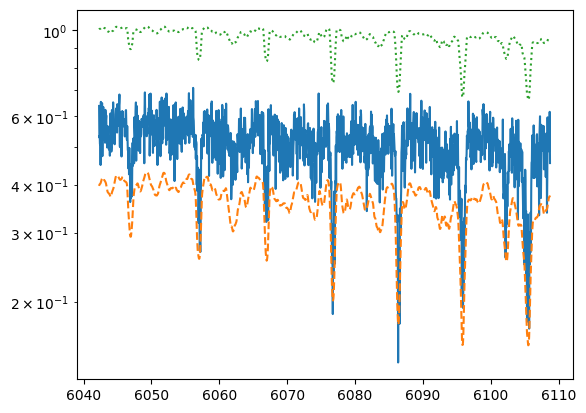

In [18]:
plt.plot(nusd, nflux)
plt.plot(nusd, Ftest, ls="dashed")
plt.plot(nusd, Ftest2, ls="dotted")
plt.yscale("log")
plt.show()

The following is the numpyro model, i.e. prior and sample.

In [19]:
def model_c(y1):
    Rp = numpyro.sample('Rp', dist.Uniform(0.4, 1.2))
    RV = numpyro.sample('RV', dist.Uniform(5.0, 15.0))
    MMR_CH4 = numpyro.sample('MMR_CH4', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0, 25.0))
    u1 = 0.0
    u2 = 0.0
    Tarr = art.powerlaw_temperature(T0, alpha)
    mu = frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini)
    numpyro.sample('y1', dist.Normal(mu, sigmain), obs=y1)

In [20]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_c, forward_mode_differentiation=True)
kernel = NUTS(model_c, forward_mode_differentiation=False)

Let’s run the HMC-NUTS. In my environment, it took ~2 hours using A4500. We observed here the number of divergences of 2.

In [21]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y1=nflux)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [2:25:22<00:00,  5.81s/it, 1023 steps of size 4.53e-03. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   MMR_CH4      0.01      0.00      0.01      0.00      0.01    459.21      1.00
        RV      9.32      0.40      9.33      8.69      9.99    547.61      1.00
        Rp      0.67      0.19      0.62      0.40      0.98    448.36      1.00
        T0   1204.92     17.17   1204.94   1174.23   1229.56    635.51      1.00
     alpha      0.10      0.01      0.10      0.10      0.11    497.56      1.00
     vsini     19.50      0.67     19.47     18.47     20.67    648.31      1.00

Number of divergences: 2


In [22]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c, posterior_sample, return_sites=['y1'])
predictions = pred(rng_key_, y1=None)
median_mu1 = jnp.median(predictions['y1'], axis=0)
hpdi_mu1 = hpdi(predictions['y1'], 0.9)

In [23]:
# PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6.0))
ax.plot(wavd[::-1], median_mu1, color='C0')
ax.plot(wavd[::-1], nflux, '+', color='black', label='data')
ax.fill_between(wavd[::-1],
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C0',
                label='90% area')
plt.xlabel('wavelength ($\AA$)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("pred_diffmode" + str(diffmode) + ".png")
plt.close()

Draw a corner plot

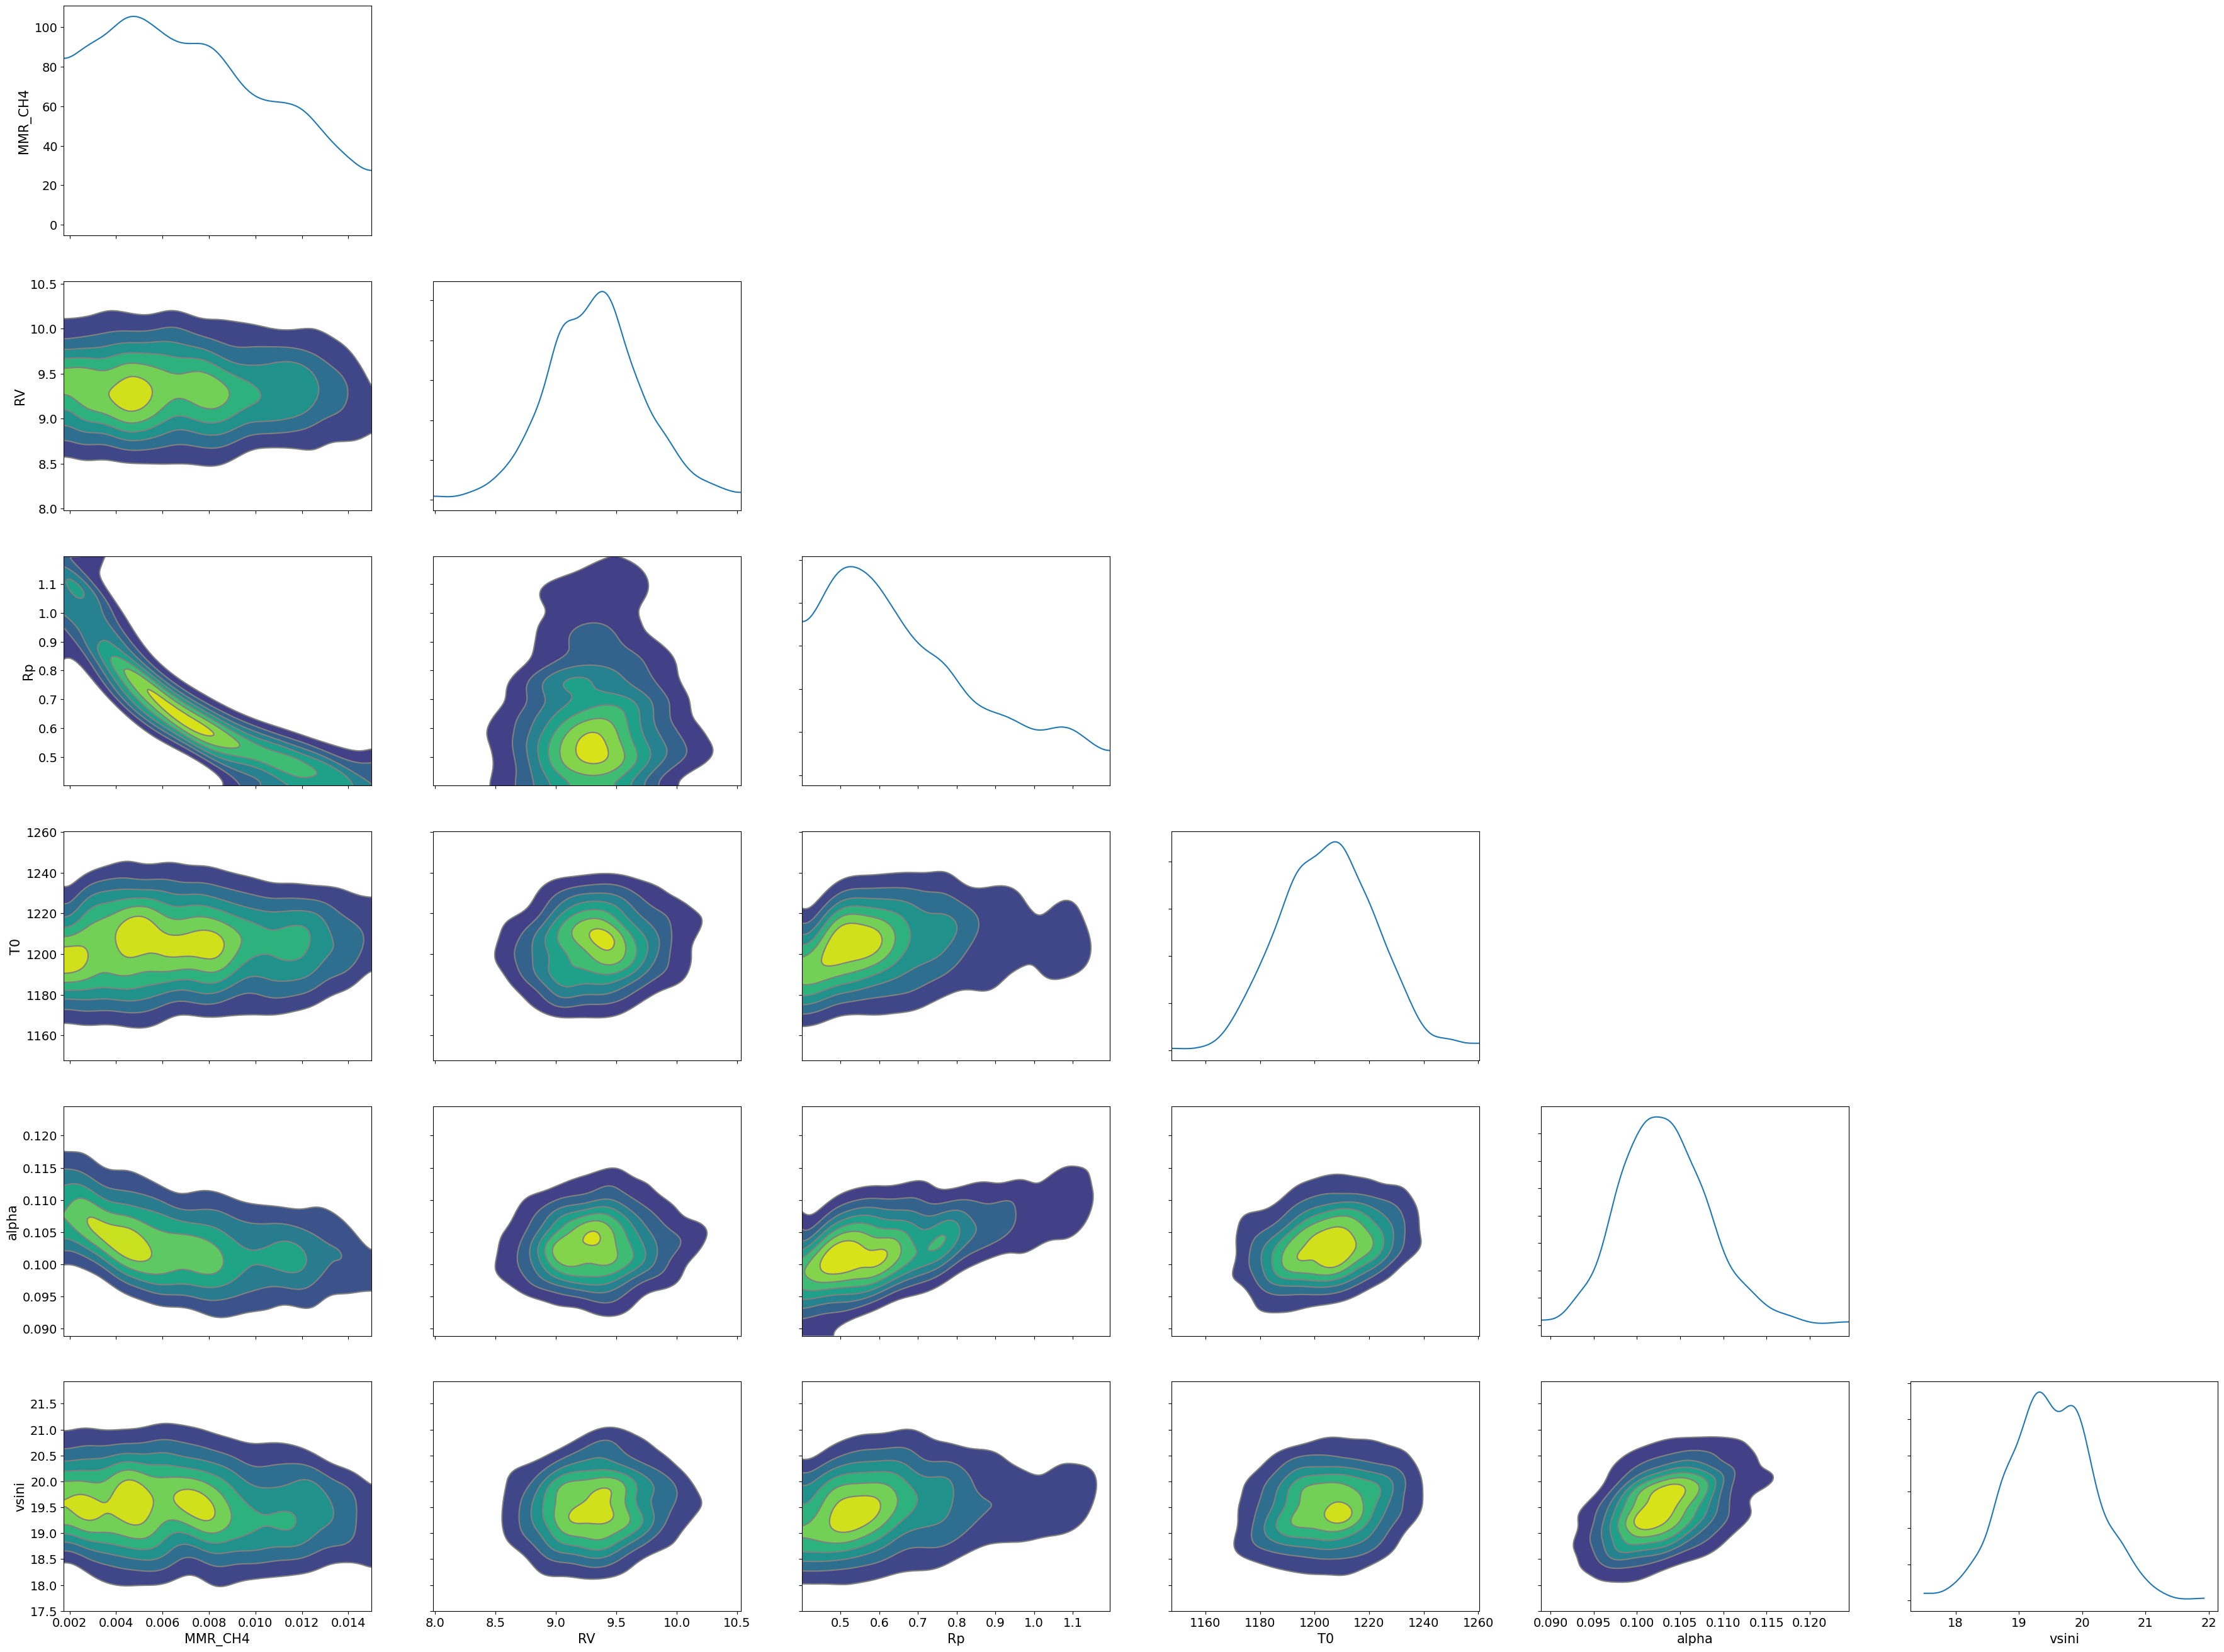

In [24]:
pararr = ['Rp', 'T0', 'alpha', 'MMR_CH4', 'vsini', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.savefig("corner_diffmode" + str(diffmode) + ".png")
#plt.show()